In [1]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import models
import matplotlib.pyplot as plt
import torch.optim as optim

We always check that we are running on a GPU

In [2]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


We provide you with a class that can load the *hotdog/not hotdog* dataset you should use from /dtu/datasets1/02514/

In [3]:
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='/dtu/datasets1/02514/hotdog_nothotdog'):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        
        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y

Below is the simple way of converting the images to something that can be fed through a network.
Feel free to use something other than $128\times128$ images.

In [77]:
size = 128

#normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                 std=[0.229, 0.224, 0.225])

train_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()
                                     ])
test_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()
                                    ])

batch_size = 128
trainset = Hotdog_NotHotdog(train=True, transform=train_transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
testset = Hotdog_NotHotdog(train=False, transform=test_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)


Let's look at some images from our data 

#### Outcomment for visulization of the dataset, remove normalization transform

In [11]:
#images, labels = next(iter(train_loader))
#plt.figure(figsize=(20,10))

#for i in range(21):
#    plt.subplot(5,7,i+1)
#    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
#    plt.title(['hotdog', 'not hotdog'][labels[i].item()])
#    plt.axis('off')


Remember to save the state of your model AND optimizer regularly in case the Colab runtime times out.
You can save your model to your google drive, so you can get it from there in a new colab session. 

If you only save it in the colab notebook, there's no way to get it into a new session.

### Creating model and training it
#### Yonking Pytorch model

In [5]:
model = models.resnet18(pretrained=True).to(device)

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters())

### Defining the training loop

In [43]:
#We define the training as a function so we can easily re-use it.
def train(model, optimizer, num_epochs=3):
    #def loss_fun(output, target):
    #    return F.nll_loss(torch.log(output), target)
    loss_fun = nn.CrossEntropyLoss()
    out_dict = {'train_acc': [],
              'test_acc': [],
              'train_loss': [],
              'test_loss': []}
  
    for epoch in tqdm(range(num_epochs), unit='epoch'):
        model.train()
        #For each epoch
        train_correct = 0
        train_loss = []
        for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            data, target = data.to(device), target.to(device)
            #Zero the gradients computed for each weight
            optimizer.zero_grad()
            #Forward pass your image through the network
            output = model(data)
            #Compute the loss
            loss = loss_fun(output, target)
            #Backward pass through the network
            loss.backward()
            #Update the weights
            optimizer.step()

            train_loss.append(loss.item())
            #Compute how many were correctly classified
            predicted = output.argmax(1)
            train_correct += (target==predicted).sum().cpu().item()
        #Comput the test accuracy
        test_loss = []
        test_correct = 0
        model.eval()
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            with torch.no_grad():
                output = model(data)
            test_loss.append(loss_fun(output, target).cpu().item())
            predicted = output.argmax(1)
            test_correct += (target==predicted).sum().cpu().item()
        out_dict['train_acc'].append(train_correct/len(trainset))
        out_dict['test_acc'].append(test_correct/len(testset))
        out_dict['train_loss'].append(np.mean(train_loss))
        out_dict['test_loss'].append(np.mean(test_loss))
        print(f"Loss train: {np.mean(train_loss):.3f}\t test: {np.mean(test_loss):.3f}\t",
              f"Accuracy train: {out_dict['train_acc'][-1]*100:.1f}%\t test: {out_dict['test_acc'][-1]*100:.1f}%")
    return out_dict

In [44]:
model_trained = train(model, optimizer, num_epochs=20)

  0%|          | 0/20 [00:00<?, ?epoch/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Loss train: 0.221	 test: 0.417	 Accuracy train: 91.0%	 test: 81.5%


  0%|          | 0/16 [00:00<?, ?it/s]

Loss train: 0.220	 test: 0.317	 Accuracy train: 91.0%	 test: 86.6%


  0%|          | 0/16 [00:00<?, ?it/s]

Loss train: 0.217	 test: 0.311	 Accuracy train: 91.2%	 test: 87.3%


  0%|          | 0/16 [00:00<?, ?it/s]

Loss train: 0.214	 test: 0.308	 Accuracy train: 91.2%	 test: 87.4%


  0%|          | 0/16 [00:00<?, ?it/s]

Loss train: 0.206	 test: 0.306	 Accuracy train: 91.3%	 test: 87.6%


  0%|          | 0/16 [00:00<?, ?it/s]

Loss train: 0.206	 test: 0.302	 Accuracy train: 91.8%	 test: 87.6%


  0%|          | 0/16 [00:00<?, ?it/s]

Loss train: 0.205	 test: 0.301	 Accuracy train: 91.5%	 test: 87.5%


  0%|          | 0/16 [00:00<?, ?it/s]

Loss train: 0.201	 test: 0.303	 Accuracy train: 91.6%	 test: 87.5%


  0%|          | 0/16 [00:00<?, ?it/s]

Loss train: 0.208	 test: 0.303	 Accuracy train: 91.5%	 test: 87.9%


  0%|          | 0/16 [00:00<?, ?it/s]

Loss train: 0.203	 test: 0.298	 Accuracy train: 92.1%	 test: 88.0%


  0%|          | 0/16 [00:00<?, ?it/s]

Loss train: 0.192	 test: 0.297	 Accuracy train: 92.3%	 test: 88.0%


  0%|          | 0/16 [00:00<?, ?it/s]

Loss train: 0.190	 test: 0.298	 Accuracy train: 93.0%	 test: 88.1%


  0%|          | 0/16 [00:00<?, ?it/s]

Loss train: 0.185	 test: 0.296	 Accuracy train: 93.1%	 test: 88.0%


  0%|          | 0/16 [00:00<?, ?it/s]

Loss train: 0.181	 test: 0.294	 Accuracy train: 93.1%	 test: 87.8%


  0%|          | 0/16 [00:00<?, ?it/s]

Loss train: 0.185	 test: 0.294	 Accuracy train: 92.4%	 test: 87.8%


  0%|          | 0/16 [00:00<?, ?it/s]

Loss train: 0.183	 test: 0.294	 Accuracy train: 92.6%	 test: 88.2%


  0%|          | 0/16 [00:00<?, ?it/s]

Loss train: 0.181	 test: 0.296	 Accuracy train: 92.4%	 test: 88.2%


  0%|          | 0/16 [00:00<?, ?it/s]

Loss train: 0.179	 test: 0.295	 Accuracy train: 92.9%	 test: 88.0%


  0%|          | 0/16 [00:00<?, ?it/s]

Loss train: 0.174	 test: 0.296	 Accuracy train: 93.1%	 test: 87.9%


  0%|          | 0/16 [00:00<?, ?it/s]

Loss train: 0.180	 test: 0.293	 Accuracy train: 92.8%	 test: 88.0%


Text(0, 0.5, 'Loss')

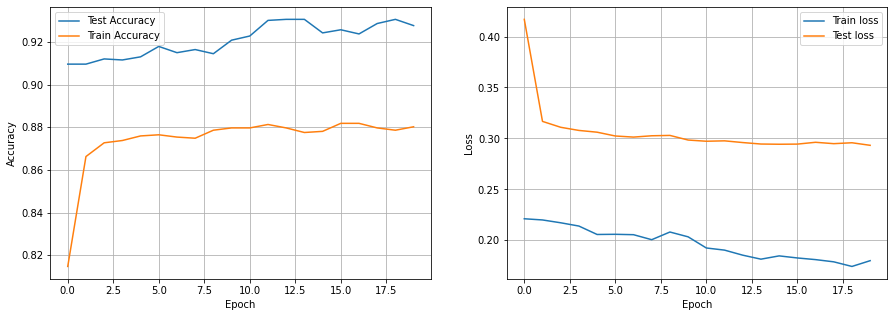

In [45]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15,5))

ax[0].plot(model_trained['train_acc'], label='train')
ax[0].plot(model_trained['test_acc'], label='test')
ax[0].grid()
ax[0].legend(('Test Accuracy','Train Accuracy'))
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')

### plot number 2
ax[1].plot(model_trained['train_loss'], label='train')
ax[1].plot(model_trained['test_loss'], label='test')
ax[1].legend(('Train loss','Test loss'))
ax[1].grid()
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')

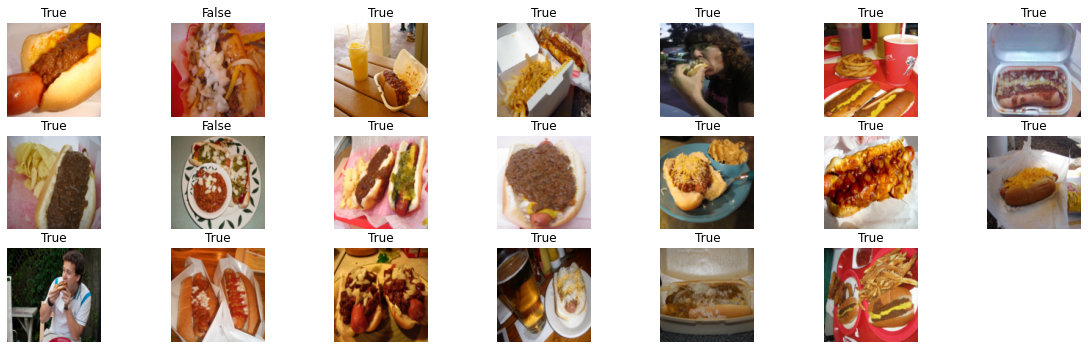

In [105]:
images, labels = next(iter(test_loader))

data = images.to(device)
with torch.no_grad():
    output = model(data)
    predicted = output.argmax(1)
    
plt.figure(figsize=(20,10))

for i in range(20):
    plt.subplot(5,7,i+1)

    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    
    plt.title(f'{labels[i] == predicted[i].item()}')
    plt.axis('off')
